In [1]:
# # connect to local datasci_env conda environment #
# ignore deprecation warnings for tidy output
import warnings
warnings.filterwarnings('ignore')

# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as geopandas
import matplotlib.cm as cm
import rasterio, folium, os
from rasterio import features
import matplotlib.pyplot as plt
from sklearn import preprocessing
from pyproj import transform, Proj
from mpl_toolkits.axes_grid1 import make_axes_locatable

# set paths to virtual raster and geopackage with geology polygons

geo_fn = r"D:\KULIAH\Makan Bang\Agromo Mountain\Qgis\Peta Geologi\Argropuro\Daerah Penelitian\Daerah Penelitian\GPKG\Daerah Penelitian Agropuro.gpkg"
vrt_fn = r"D:\KULIAH\Makan Bang\Agromo Mountain\Qgis\Virtual Raster\vrt 14.vrt"

# set output image directory
outim_dir = r"D:\KULIAH\Makan Bang\Agromo Mountain\Hasil"


In [2]:
# read 1:100,000 geology into a geopandas data frame
gdf = geopandas.read_file(geo_fn)

# generate an interactive folium map with Google's hybrid satellite imagery
map = folium.Map(location=[-7.4038465, 112.5360825], zoom_start=9,
                 tiles='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
                 attr = 'Google', name = 'Google Satellite', overlay = True,
                 control = True)

# overlay geology polygons and plot the map
folium.Choropleth(geo_data=gdf.geometry, fill_opacity=0.0).add_to(map)
map

In [3]:
# create a new unit column for simplified unit names
gdf['unit'] = gdf['NAMOBJ']
print(gdf)

   ET_ID  Shape_Leng  Shape_Area  map_id  theme_id  map_indeks  map_name  \
0    205    1.008175    0.045093       0         0         NaN       NaN   
1  14001   21.012366    0.532902       0         0         NaN       NaN   
2  16117    0.037721    0.000099       0         0         NaN       NaN   
3  21037    3.214346    0.156706       0         0         NaN       NaN   
4     99    0.308871    0.004954       0         0         NaN       NaN   
5    205    1.008175    0.045093       0         0         NaN       NaN   
6  15680    2.721735    0.042465       0         0         NaN       NaN   
7  21037    3.214346    0.156706       0         0         NaN       NaN   

   scale_id  regi_pv_id  regi_ds_id  ...  SIMOBJ  \
0         0           0           0  ...    Qvl3   
1         0           0           0  ...     Qal   
2         0           0           0  ...      Qi   
3         0           0           0  ...   Qpva1   
4         0           0           0  ...    Qaf1   
5  

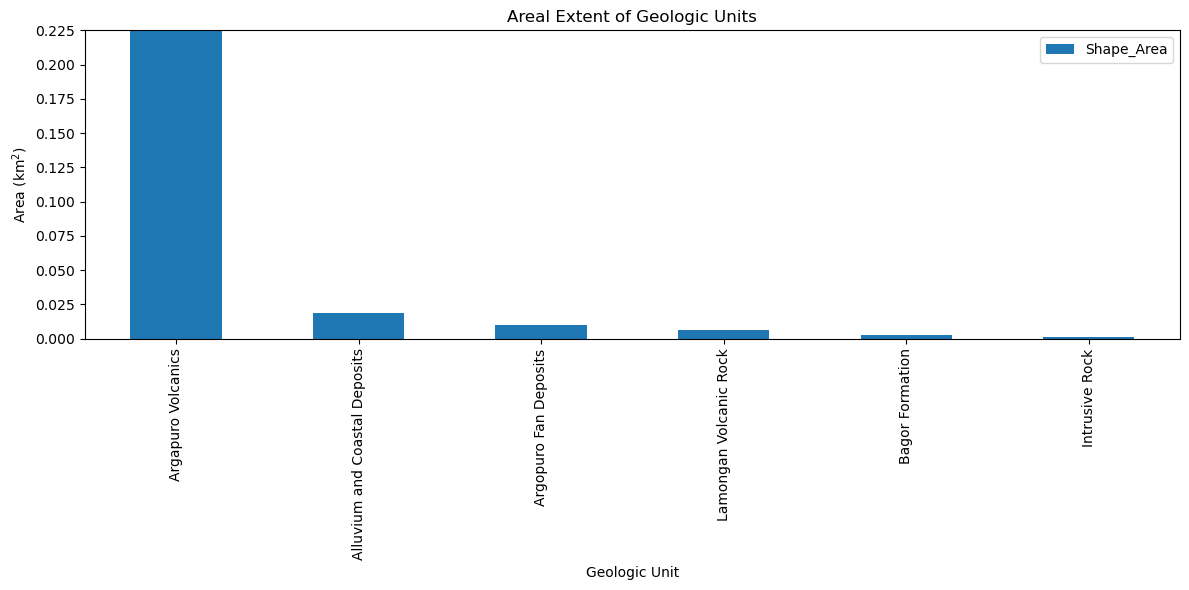

In [4]:
# create a data frame to store area values, sort it by descending area
area_df = pd.DataFrame(columns=['unit','Shape_Area'])
for i, unit in enumerate(gdf.unit.unique()):
  area_df.loc[i, 'unit'] = unit
  area_df.loc[i, 'Shape_Area'] = gdf[gdf.unit == unit].area.sum() / 0.1
area_df = area_df.sort_values(by='Shape_Area', ascending=False).reset_index(drop=True)

# plot a bar chart
fig, ax = plt.subplots(figsize=(12,6))
area_df.plot.bar(x='unit', y='Shape_Area', ax=ax)

# add rounded area value to each bar
for p in ax.patches:
  ax.annotate(round(p.get_height(),1), (p.get_x()-0.2, p.get_height()+30), rotation=45)

# add axis labels and title
ax.set(title='Areal Extent of Geologic Units',
       ylabel='Area (km$^2$)', xlabel='Geologic Unit', ylim=(0, 0.225))

plt.tight_layout()
plt.savefig(os.path.join(outim_dir,'f1_unit_area_extent.png'), dpi=250)
plt.show()

Number of unique unit names: 6 
---------


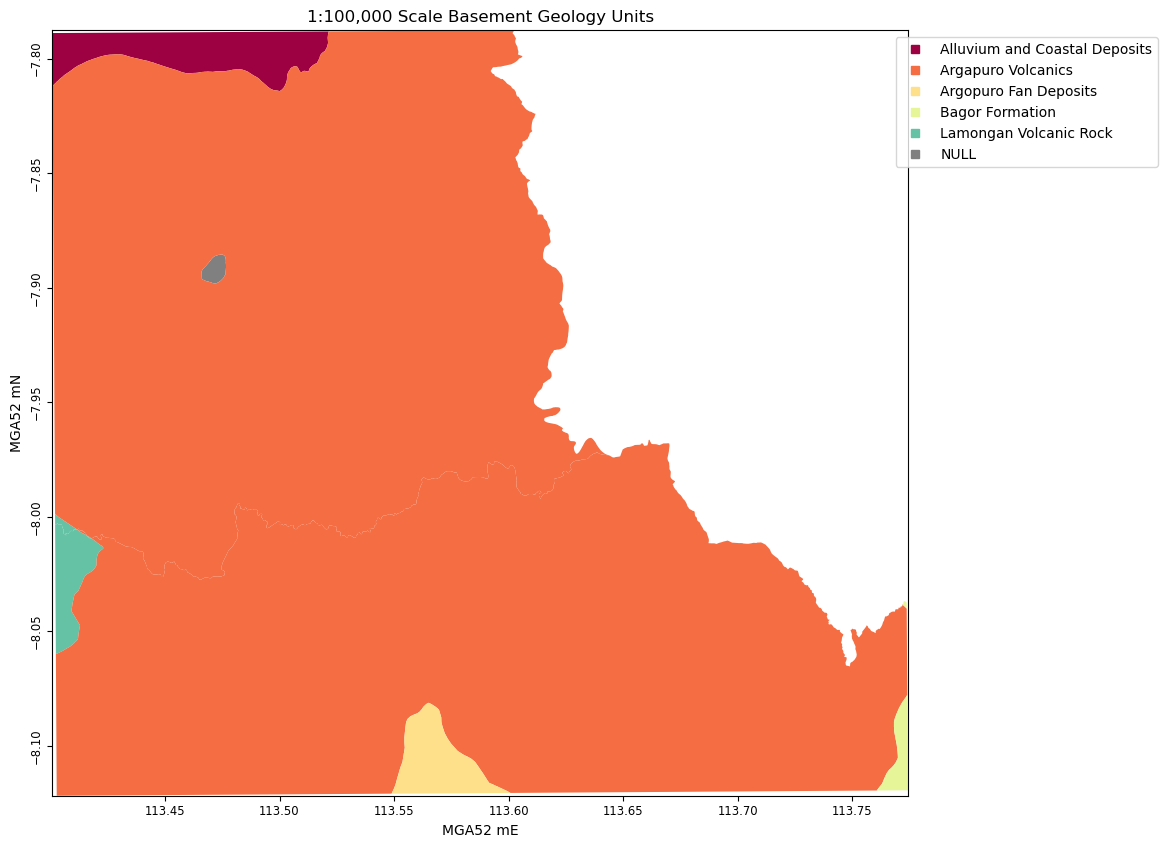

In [5]:
# get a list of units with areal extent less than 30 sqkm, set these to 'NULL'
null_units = area_df.loc[area_df.Shape_Area < 0.0025, 'unit'].values.tolist()
gdf.loc[gdf.unit.isin(null_units), 'unit'] = 'NULL'
print ('Number of unique unit names:', len(gdf.unit.unique()), '\n---------')

# get a list of colours from a named colourmap, build a colour dictionary
cmap = cm.get_cmap('Spectral', len(gdf.unit.unique()))
unit_clrs = [cmap(i) for i in range(len(gdf.unit.unique())-1)]
colour_dict = dict(zip(sorted(gdf[gdf.unit!='NULL'].unit.unique()), unit_clrs))

# make 'NULL' units grey
colour_dict.update({'NULL':'grey'})

# plot the units with colour dictionary colours
fig, ax = plt.subplots(figsize=(12,12))
for unit in gdf.unit.unique():
  gdf[gdf.unit==unit].plot(column='unit', ax=ax,  color=colour_dict[unit])

# fix the axis labels
ax.set(title='1:100,000 Scale Basement Geology Units',
       ylabel='MGA52 mN', xlabel='MGA52 mE', aspect=1,
       ylim=(gdf.total_bounds[[1,3]]), xlim=(gdf.total_bounds[[0,2]]))
ax.ticklabel_format(style='plain')
plt.setp(ax.get_yticklabels(),va='center',rotation='vertical',fontsize='small')
plt.setp(ax.get_xticklabels(),fontsize='small')

# generate a legend and add to plot
markers = [plt.Line2D([0,0],[0,0],color=c, marker='s', linestyle='') for c in colour_dict.values()]
leg = ax.legend(markers, colour_dict.keys(), numpoints=1)
leg.set_bbox_to_anchor((0, 0, 1.3, 1))

plt.tight_layout()
plt.savefig(os.path.join(outim_dir,'f2_vector_geology_units.png'), dpi=150)
plt.show()

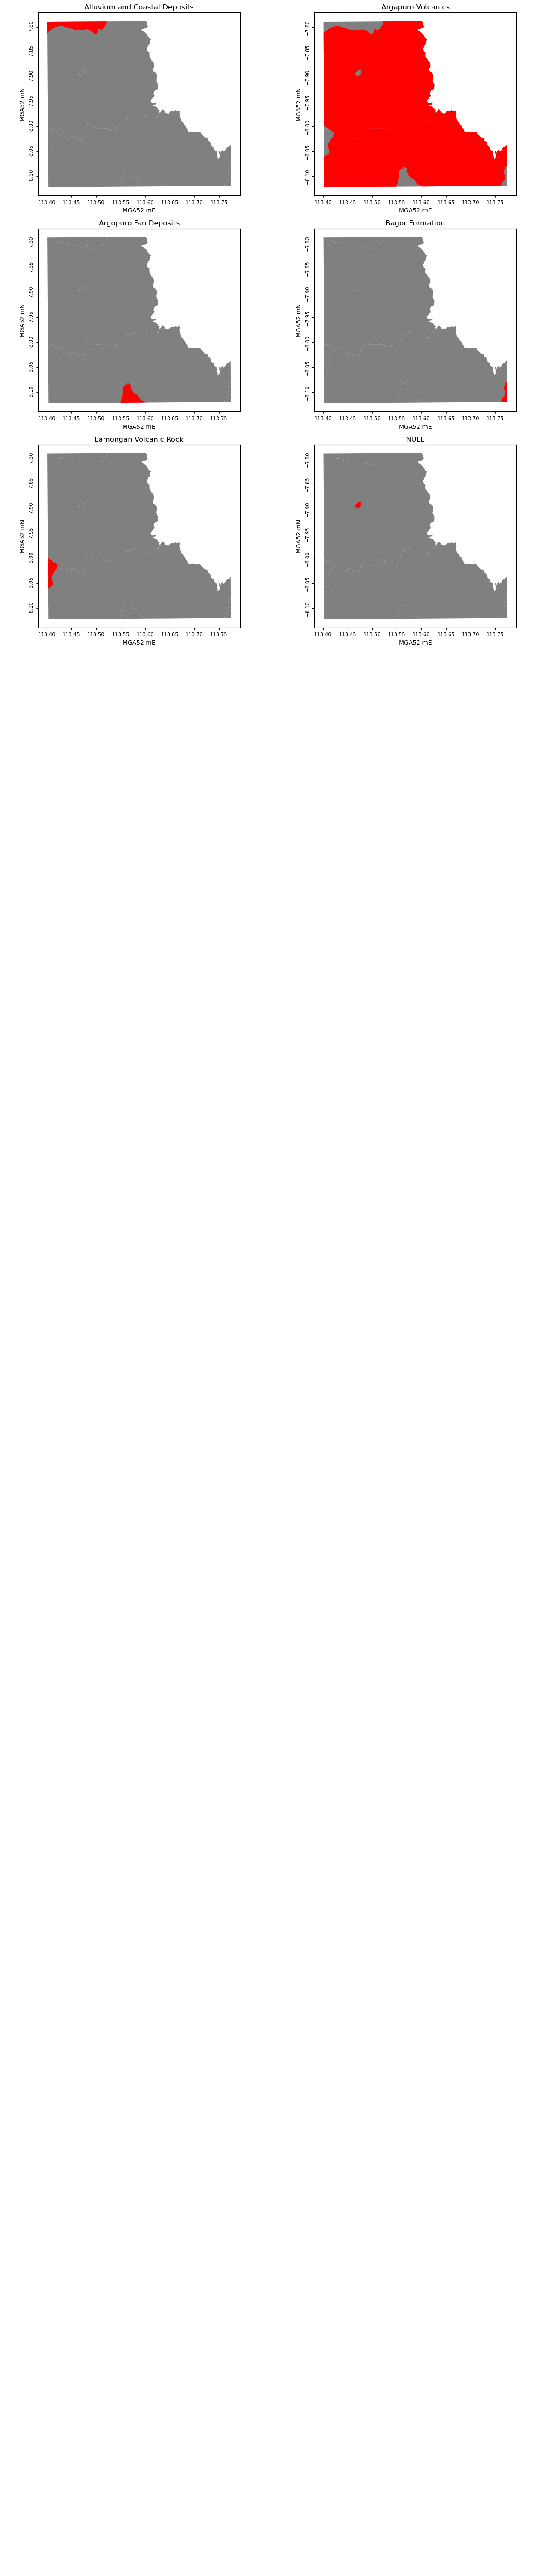

In [6]:
# plot each unit highlighted in red
fig, axes = plt.subplots(12,2,figsize=(13,60))

# loop through flattened axes with iterator i
for i, ax in enumerate(axes.flatten()):
  # proceed if iterator i is less than length of unique units
  if i < len(gdf.unit.unique()):
    # get current unit
    unit = sorted(gdf.unit.unique())[i]
    # add all geology in light grey
    gdf.plot(column='unit', ax=ax, color='grey')
    # add current lithology in red
    gdf[gdf.unit==unit].plot(column='unit', ax=ax, color='red')
    # add axes labels and plot title
    ax.ticklabel_format(style='plain')
    ax.set(title=unit, ylabel='MGA52 mN', xlabel='MGA52 mE')
    plt.setp(ax.get_yticklabels(),va='center',rotation='vertical',fontsize='small')
    plt.setp(ax.get_xticklabels(),fontsize='small')
  # if iterator is larger than length of unit labels, don't plot an axis
  else:
    ax.axis('off')

# show the plot
plt.tight_layout()
plt.show()

In [7]:
# open virtual raster with rasterio
with rasterio.open(vrt_fn) as src:
  # loop through band indexes, read into array, append to list, convert to array
  data_list = []
  for i in src.indexes:
    data_list.append(src.read(indexes=i).astype('float32')) # force common dtype
  data_ar = np.array(data_list) 

  # read some of grid parameters into arrays for later use
  no_data_vals = list(src.nodatavals)
  xmin, xmax = src.bounds.left, src.bounds.right
  ymin, ymax = src.bounds.bottom, src.bounds.top
  x_ar = np.linspace(start=xmin, stop=xmax, num=src.width)
  y_ar = np.linspace(start=ymin, stop=ymax, num=src.height)
  dx, dy = np.abs(x_ar[0] - x_ar[1]), np.abs(y_ar[0] - y_ar[1]) 
  extent = (xmin, xmax, ymin, ymax)
  data_bands = [os.path.basename(x).replace('.tif','').upper() for x in src.files if 'vrt' not in x]
  data_bands = np.array(data_bands)

  # print some details about the multiband raster
  print ('Indexes of data bands in the virtual raster: ', list(src.indexes))
  print ('Number of pixels in x-direction: ', src.width)
  print ('Number of pixels in y-direction: ', src.height)
  print ('Multiband raster array shape: ', data_ar.shape)
  print ('Pixel resolution: ', dx, 'm')
  src.close()

Indexes of data bands in the virtual raster:  [1, 2]
Number of pixels in x-direction:  1363
Number of pixels in y-direction:  1218
Multiband raster array shape:  (2, 1218, 1363)
Pixel resolution:  0.00027420708357794865 m


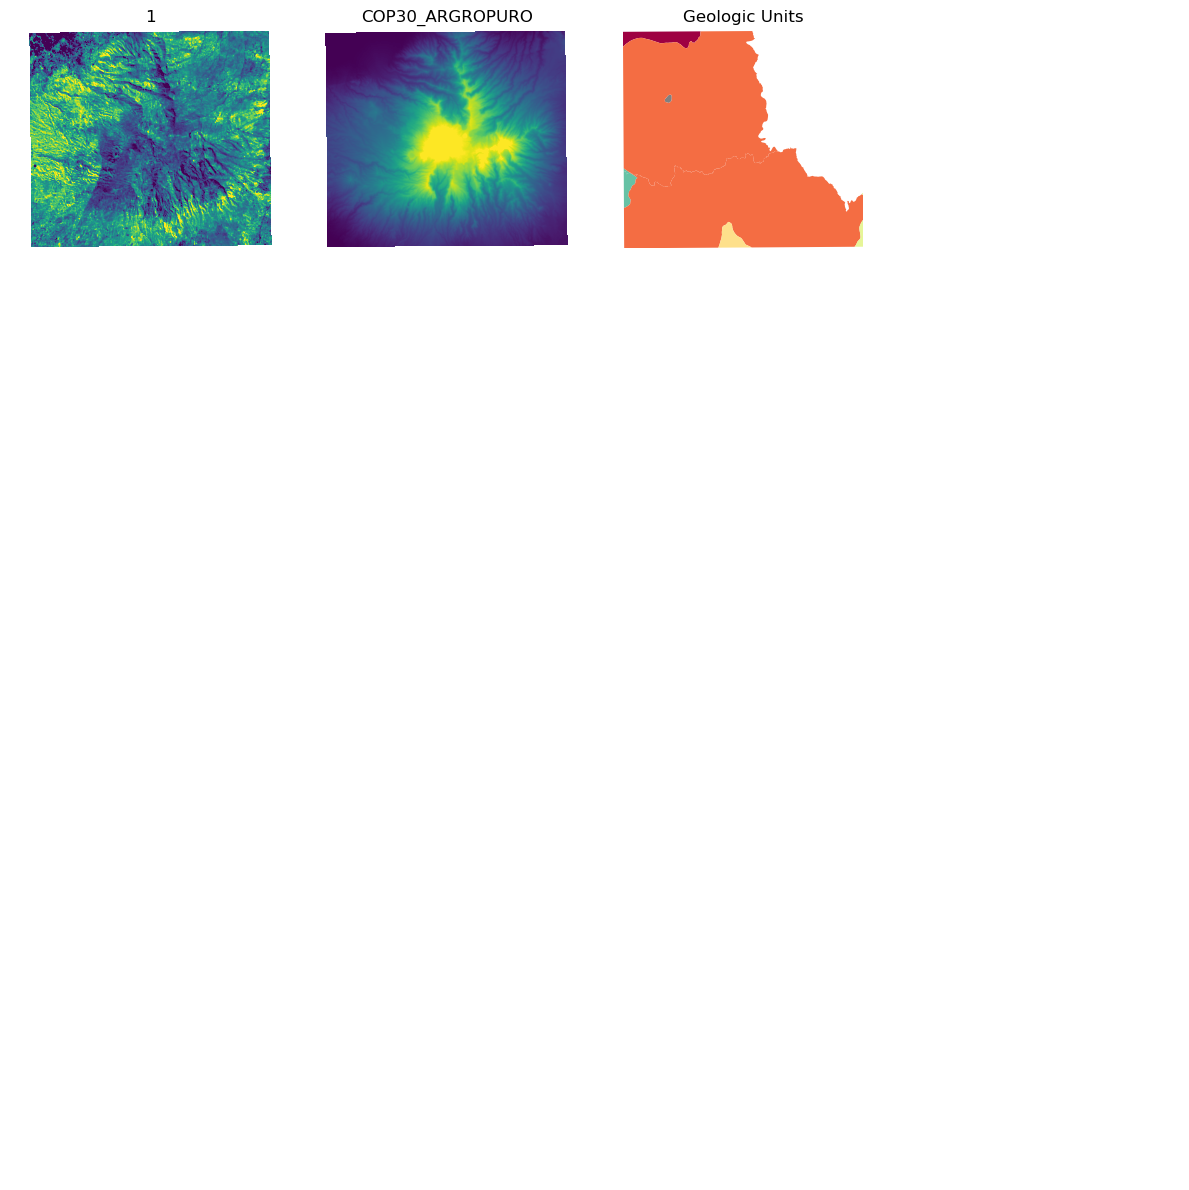

In [8]:
# import astropy simple_norm for 95% colour normalisation
from astropy.visualization import simple_norm

# edit the SRTM raster to remove values > 5000m and < 0m
data_ar[-1, data_ar[-1] > 5000] = np.nan
data_ar[-1, data_ar[-1] < 0] = np.nan

# loop through the data array bands and make no_data pixels equal to np.nan
for i in range(0,len(data_bands)):
  for val in no_data_vals:
    data_ar[i,data_ar[i]==val] = np.nan

# set up a boolean mask array based on the last of the data bands
nulls = np.invert(np.isnan(data_ar[-1]))

# loop through the data bands and no_data values to build a master boolean null
# mask to apply to all raster bands
for i in range(0, len(src.indexes)):
  nulls = nulls * np.invert(np.isnan(data_ar[i]))

# apply the master null mask to all data array bands
nulls = np.invert(nulls)
data_ar[:,nulls] = np.nan

# set up a subplot figure
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(12,12))

# loop through plot axes
for i, ax in enumerate(axes.flatten()):
  # proceed if i is less than number of data bands
  if i < data_ar.shape[0]:
    # generate a linear colour stretch clipped to 95% of the data
    norm = simple_norm(data_ar[i], stretch='linear', percent=95)
    # plot the raster layer using the normalised colour stretch, set title
    ax.imshow(data_ar[i], extent=extent, norm=norm, cmap='viridis')
    ax.set(title=data_bands[i])
  # plot geologic units on len(data_ar)th subplot axis
  if i == len(data_ar):
    ax.set(title='Geologic Units')
    for unit in gdf.unit.unique():
      gdf[gdf.unit==unit].plot(column='unit', ax=ax,  color=colour_dict[unit])
    ax.set_xlim(extent[0],extent[1])
    ax.set_ylim(extent[2],extent[3])
  ax.axis('off')

# plot the rasters
plt.tight_layout()
plt.savefig(os.path.join(outim_dir,'f3_raster_data_sets.png'), dpi=250)
plt.show()

In [9]:
# generate numerical codes for each of the unique units in the dataframe
gdf['unit_num'] = np.nan
for i, unit in enumerate(sorted(gdf.loc[gdf.unit!='NULL', 'unit'].unique())):
  gdf.loc[gdf.unit==unit, 'unit_num'] = i 
gdf.loc[gdf.unit=='NULL', 'unit_num'] = gdf.unit_num.max() + 1

# build a dictionary for the unit and corresponding unit number
unit_dict = dict(zip(gdf.unit_num, gdf.unit))

# open the virtual raster again
with rasterio.open(vrt_fn, 'r') as src:
  # read the first raster band into a temporary array called tmp
  tmp_ar = src.read(1) * np.nan
  # get the shapes and unit_nums from the geopandas data frame
  shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf.unit_num))
  # rasterise the shapes into an array called unit_ar and close src
  unit_ar = features.rasterize(shapes=shapes, out=tmp_ar, transform=src.transform)
  src.close()

# print raster dimensions and unit numbers
print ('Rasterised geologic unit numpy array has shape:', unit_ar.shape)
print ('\nUnit numbers corresponding to geologic units:')
for i in range(len(unit_dict)):
  print ('   Unit number %s corresponds to %s'%(i, unit_dict[i]))

Rasterised geologic unit numpy array has shape: (1218, 1363)

Unit numbers corresponding to geologic units:
   Unit number 0 corresponds to Alluvium and Coastal Deposits
   Unit number 1 corresponds to Argapuro Volcanics
   Unit number 2 corresponds to Argopuro Fan Deposits
   Unit number 3 corresponds to Bagor Formation
   Unit number 4 corresponds to Lamongan Volcanic Rock
   Unit number 5 corresponds to NULL


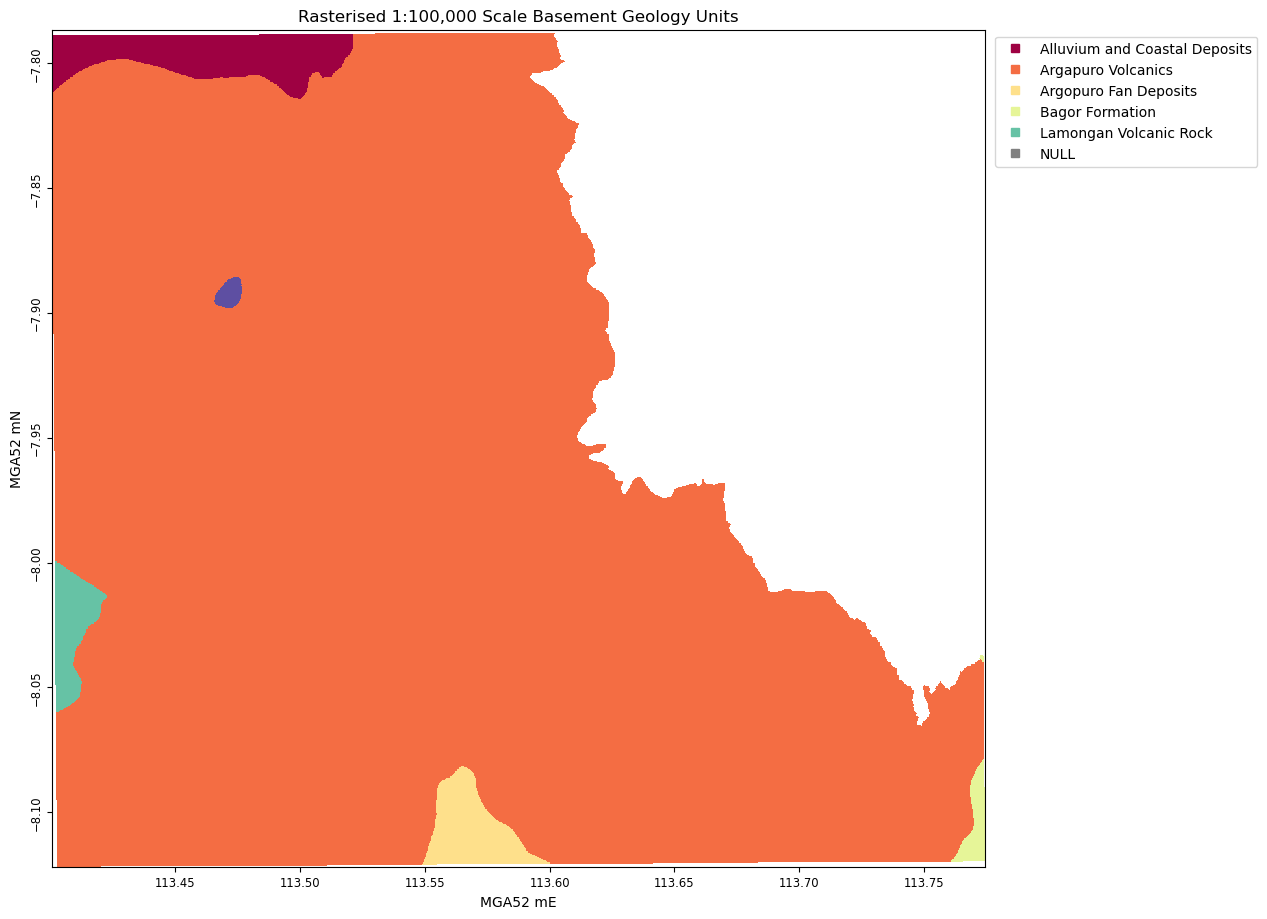

In [10]:
# plot the geology raster 
fig, ax = plt.subplots(figsize=(13,12))
im = ax.imshow(unit_ar, extent=extent, cmap='Spectral', interpolation='nearest')

# edit the tick labels and add a title 
ax.set(title='Rasterised 1:100,000 Scale Basement Geology Units',
       ylabel='MGA52 mN', xlabel='MGA52 mE', aspect=1)
ax.ticklabel_format(style='plain')
plt.setp(ax.get_yticklabels(),va='center',rotation='vertical',fontsize='small')
plt.setp(ax.get_xticklabels(),fontsize='small')

# generate a legend and add to plot
markers = [plt.Line2D([0,0],[0,0],color=c, marker='s', linestyle='') for c in colour_dict.values()]
leg = ax.legend(markers, colour_dict.keys(), numpoints=1)
leg.set_bbox_to_anchor((0, 0, 1.3, 1))

plt.tight_layout()
plt.show()

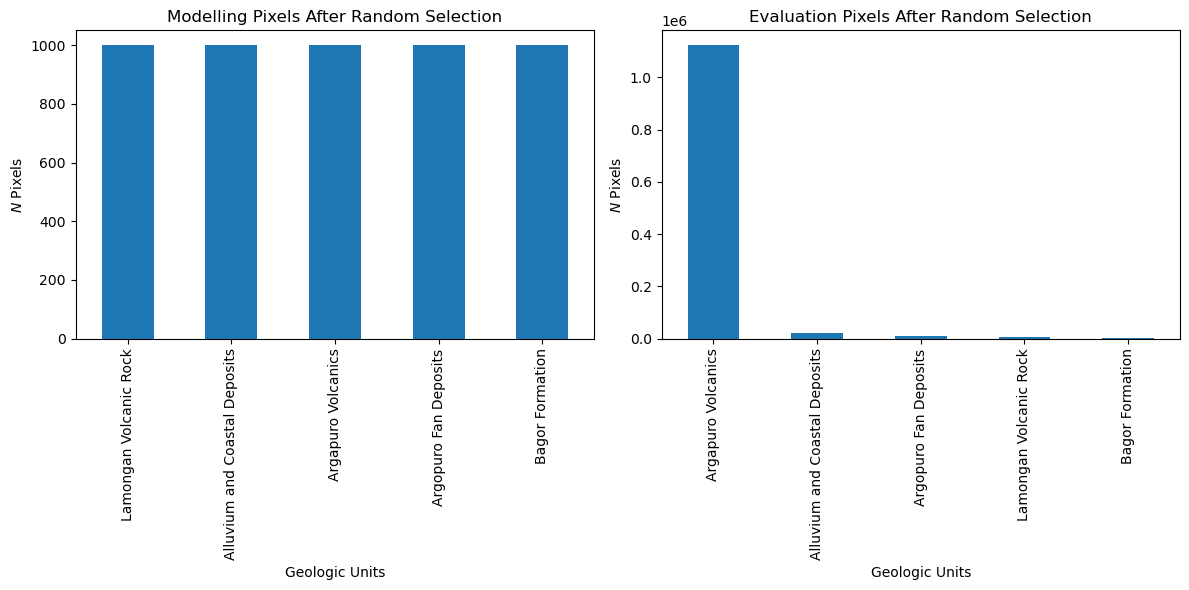

In [11]:
# make a copy of the raster data array, reshape it to 2D with rows representing 
# indidual pixels and columns representing raster bands
mod_ar = data_ar.copy()
mod_ar = mod_ar.reshape((data_ar.shape[0], data_ar.shape[1] * data_ar.shape[2]))

# scale the pixel data to the unit variance (the 'z-score')
for i in range(mod_ar.shape[0]):
  mod_ar[i] = preprocessing.scale(mod_ar[i])

# transpose the mod_ar array
mod_ar = mod_ar.T

# make a copy of the unit_ar, flatten it and use it to define which pixels belong
# to which lithology
mod_unit = unit_ar.copy()
mod_unit = mod_unit.flatten()

# flatten the nulls array and remove elements in both the mod_ar array and the 
# mod_unit arrays where pixels are null
nonnull_idx = np.argwhere(nulls.flatten() == False).flatten()
mod_ar = mod_ar[nonnull_idx]
mod_unit = mod_unit[nonnull_idx]

# set a random seed for repeatability
np.random.seed(42)

# construct a data frame into which we'll inset pixel data for modelling
mod_df = pd.DataFrame(columns=data_bands.tolist() + ['unit_num'])

# construct a evaulation data frame into which we'll insert pixel data for 
# model evaluation
eval_df = pd.DataFrame(columns=data_bands.tolist() + ['unit_num'])

# loop through unique unit_num values and select 1000 pixels at random
for unit_num in gdf.unit_num.unique():
  # find index in mod_unit array with this unit_num
  unit_idx = np.argwhere(mod_unit == unit_num).flatten()  
  # if there are more than 1000 pixels in the unit_idx array, randomly select 
  # 1000 pixels using the np.random.choice function
  if len(unit_idx) >= 1000:
    keep_idx = np.random.choice(unit_idx, 1000, replace=False)
    eval_idx = unit_idx[~np.in1d(unit_idx, keep_idx)]
    # create a temporary modeling data frame with these randomly selected pixels 
    tmp_mod = pd.DataFrame(data=mod_ar[keep_idx], columns=data_bands)
    # create a temporary evaluation data frame for remaining pixel values
    tmp_eval = pd.DataFrame(data=mod_ar[eval_idx], columns=data_bands)
    # add the current unit_num label
    tmp_mod['unit_num'] = unit_num
    tmp_eval['unit_num'] = unit_num
    # concatenate this temporary data frame with the mod_df and eval_df
    mod_df = pd.concat([mod_df, tmp_mod], ignore_index=True)
    eval_df = pd.concat([eval_df, tmp_eval], ignore_index=True)
  else:
    print ('ಠ_ಠ not enough pixels.')

# add a column for unit labels
mod_df['unit_label'] = mod_df.unit_num.map(unit_dict)
eval_df['unit_label'] = eval_df.unit_num.map(unit_dict)

# remove NULL units
mod_df = mod_df[mod_df.unit_label != 'NULL']
eval_df = eval_df[eval_df.unit_label != 'NULL']

# plot the mod_df and eval_df pixel counts side by side
fig, ax = plt.subplots(1,2,figsize=(12,6))
mod_df.unit_label.value_counts().plot(kind='bar', ax=ax[0])
ax[0].set(title='Modelling Pixels After Random Selection', ylabel='$N$ Pixels',
          xlabel='Geologic Units')

eval_df.unit_label.value_counts().plot(kind='bar', ax=ax[1])
ax[1].set(title='Evaluation Pixels After Random Selection', ylabel='$N$ Pixels',
          xlabel='Geologic Units')

plt.tight_layout()
plt.savefig(os.path.join(outim_dir,'f4_mod_eval_datasets.png'), dpi=250)
plt.show()

In [12]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Split the modelling DataFrame into training and testing subsets
train_df, test_df = train_test_split(mod_df[data_bands.tolist() + ['unit_num']],
                                     test_size=0.3, shuffle=True)

# Prepare the feature matrix (X) and the target vector (y) for both training and testing sets
X_train = train_df[data_bands]
y_train = train_df['unit_num']
X_test = test_df[data_bands]
y_test = test_df['unit_num']

# Initialize the Random Forest classifier with desired parameters
# You can adjust the parameters according to your needs
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Train the Random Forest model on the training set
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# You can also print the classification report to get more details on the model's performance
print(classification_report(y_test, y_pred))


Accuracy: 0.75
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96       297
         1.0       0.84      0.56      0.67       303
         2.0       0.54      0.66      0.59       304
         3.0       0.97      0.98      0.98       314
         4.0       0.49      0.50      0.50       282

    accuracy                           0.75      1500
   macro avg       0.75      0.74      0.74      1500
weighted avg       0.76      0.75      0.74      1500



In [13]:
# import the get_confusion_matrix function from catboost
from catboost.utils import get_confusion_matrix

# # convert confusion matrix array to data frame
cm_df = pd.DataFrame(get_confusion_matrix(rf_model, test_pool), 
                     columns=[unit_dict[x] for x in model.classes_])
cm_df.index = [unit_dict[x] for x in model.classes_]

# convert entries to percent
pct_cm_df = cm_df.div(cm_df.sum(axis=1), axis=0).multiply(100).round(1)

# generate a square root colourmap normalisation on 90% of the prediction percentages
norm_cmap = simple_norm(pct_cm_df.values.flatten(), stretch='sqrt', percent=90)

# plot the confusion matrix
fig, ax = plt.subplots(figsize=(15,15)) 

sns.heatmap(pct_cm_df, fmt='g',
            xticklabels=pct_cm_df.columns, yticklabels=pct_cm_df.columns,
            cmap='Blues',annot=True,linewidths=1,linecolor='black',
            norm=norm_cmap, ax=ax,cbar=True,vmin=0,vmax=100,
            cbar_kws={'shrink':0.5,'label':'Prediction %'})
cbar = ax.collections[-1].colorbar.outline.set_linewidth(1)
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')
ax.set_title('Confusion Matrix - Testing Data Set')
ax.set_aspect(1)

plt.tight_layout()
plt.show()

NameError: name 'test_pool' is not defined

Accuracy: 0.716
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       190
         1.0       0.67      0.67      0.67       192
         2.0       0.51      0.51      0.51       210
         3.0       0.98      0.98      0.98       192
         4.0       0.50      0.49      0.50       216

    accuracy                           0.72      1000
   macro avg       0.72      0.73      0.73      1000
weighted avg       0.71      0.72      0.72      1000



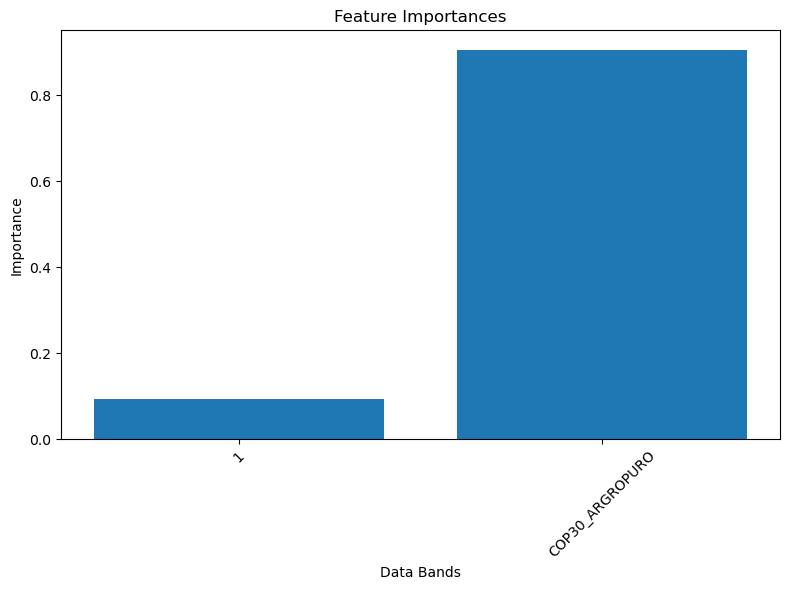

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Construct a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Split the data into training and evaluation sets
X_train, X_eval, y_train, y_eval = train_test_split(mod_df[data_bands], mod_df['unit_num'], test_size=0.2, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Make predictions on the evaluation set
y_pred = rf.predict(X_eval)

# Calculate the accuracy and print the classification report
accuracy = accuracy_score(y_eval, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_eval, y_pred))

# Get the feature importances
feature_importances = rf.feature_importances_

# Plot the feature importances
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(data_bands, feature_importances)
ax.set(title="Feature Importances", xlabel="Data Bands", ylabel="Importance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer

# Split the modelling DataFrame into training and testing subsets
train_df, test_df = train_test_split(mod_df[data_bands.tolist() + ['unit_num']],
                                     test_size=0.3, shuffle=True)

# Prepare the feature matrix (X) and the target vector (y) for both training and testing sets
X_train = train_df[data_bands]
y_train = train_df['unit_num']
X_test = test_df[data_bands]
y_test = test_df['unit_num']

# Handle missing values
imputer = SimpleImputer(strategy='mean')  # You can choose other strategies like 'median' or 'most_frequent'
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Initialize the Random Forest classifier with desired parameters
# You can adjust the parameters according to your needs
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Train the Random Forest model on the training set
rf_model.fit(X_train_imputed, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test_imputed)

# Create a confusion matrix
cm_array = confusion_matrix(y_test, y_pred)

# Convert confusion matrix array to a DataFrame
unit_dict_inverse = {v: k for k, v in unit_dict.items()}
cm_df = pd.DataFrame(cm_array, columns=[unit_dict_inverse[x] for x in rf_model.classes_])
cm_df.index = [unit_dict_inverse[x] for x in rf_model.classes_]

# Convert entries to percentages
pct_cm_df = cm_df.div(cm_df.sum(axis=1), axis=0).multiply(100).round(1)

# Generate a square root colourmap normalisation on 90% of the prediction percentages
norm_cmap = simple_norm(pct_cm_df.values.flatten(), stretch='sqrt', percent=90)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(15, 15)) 

sns.heatmap(pct_cm_df, fmt='g',
            xticklabels=pct_cm_df.columns, yticklabels=pct_cm_df.columns,
            cmap='Blues', annot=True, linewidths=1, linecolor='black',
            norm=norm_cmap, ax=ax, cbar=True, vmin=0, vmax=100,
            cbar_kws={'shrink': 0.5, 'label': 'Prediction %'})
cbar = ax.collections[-1].colorbar.outline.set_linewidth(1)
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')
ax.set_title('Confusion Matrix - Testing Data Set')
ax.set_aspect(1)

plt.tight_layout()
plt.show()


KeyError: 0.0

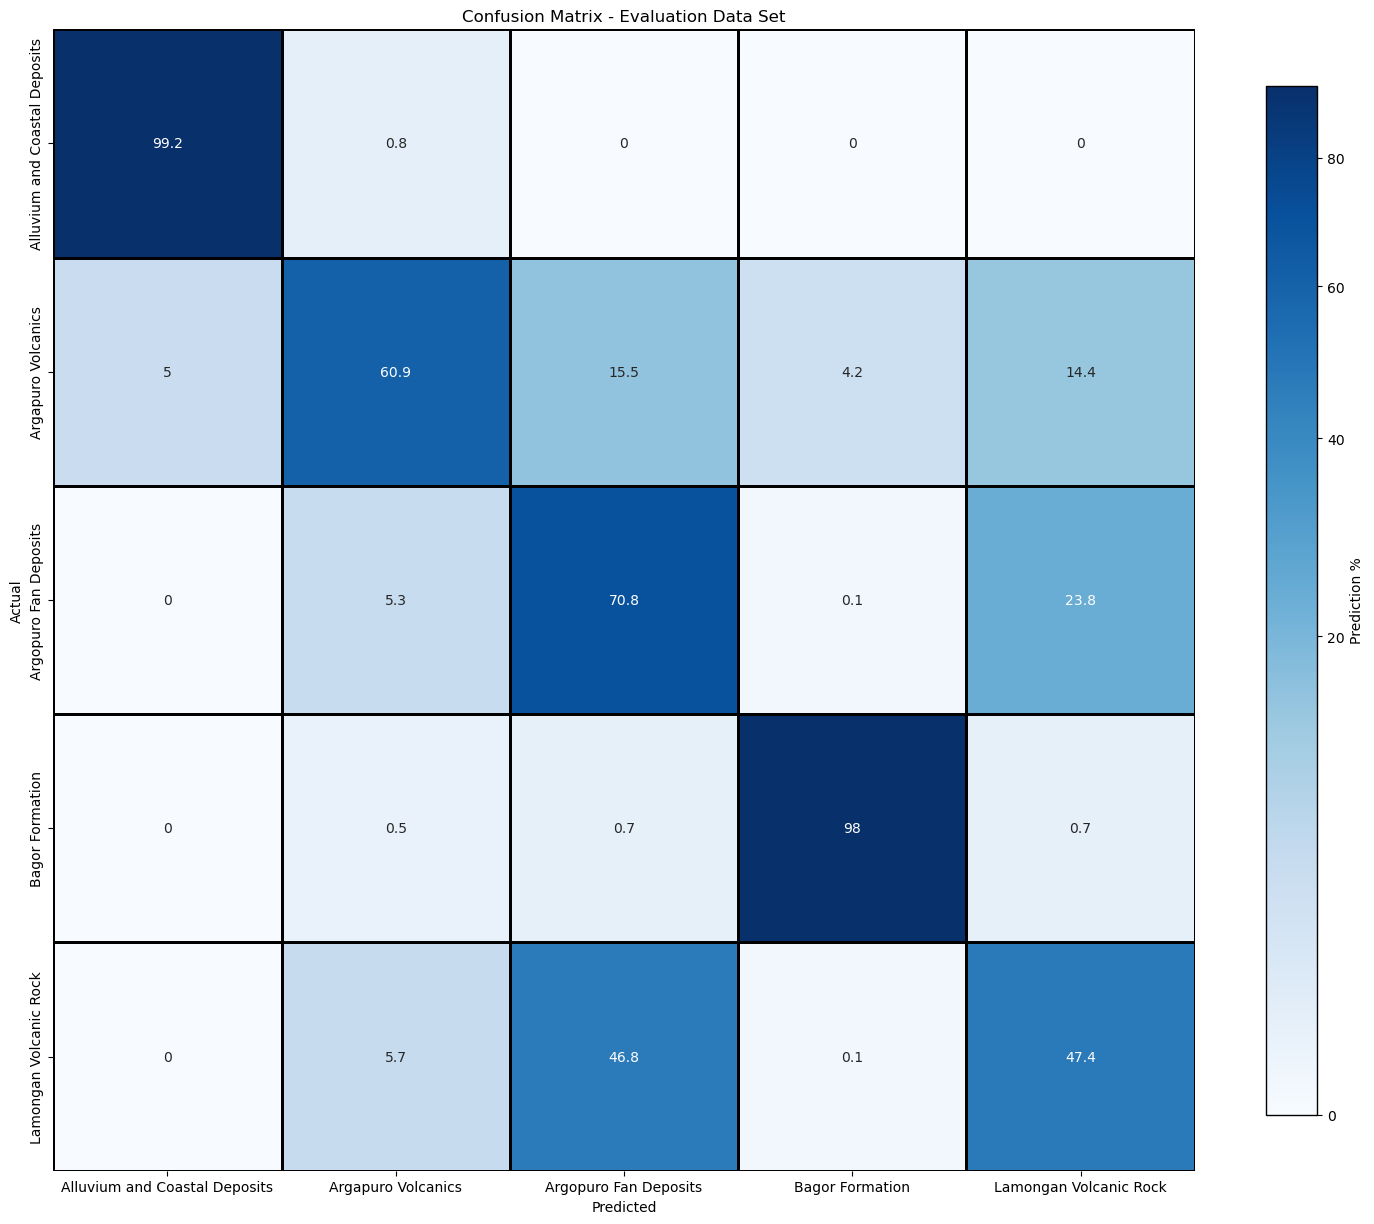

In [16]:
# extract the data band values from the eval_df data frame
eval_d = eval_df[data_bands].values

# predict onto this data set
eval_unit = rf_model.predict(eval_d)

# append the predictions onto the eval_df data frame
eval_df['pred_unit_num'] = eval_unit

# add unit codes for these predictions
eval_df['pred_unit_label'] = eval_df.pred_unit_num.map(unit_dict)

# build a confusion matrix array from the model class numbers
classes = [x for x in rf_model.classes_]
cm_ar = np.zeros((len(classes), len(classes)))

# loop through number of classes and fill the confusion matrix array with data
for i, iclass in enumerate(classes):
  for j, jclass in enumerate(classes):
    mask = (eval_df['unit_num'] == iclass) & (eval_df['pred_unit_num'] == jclass)
    index = np.argwhere(mask.values == True)
    cm_ar[i,j] = len(index)

# convert confusion matrix array to data frame, and convert entries to percent
cm_df = pd.DataFrame(cm_ar, columns=[unit_dict[x] for x in rf_model.classes_])
cm_df.index = [unit_dict[x] for x in rf_model.classes_]
pct_cm_df = cm_df.div(cm_df.sum(axis=1), axis=0).multiply(100).round(1)

# generate a square root colourmap normalisation on 90% of the prediction percentages
norm_cmap = simple_norm(pct_cm_df.values.flatten(), stretch='sqrt', percent=90)

# plot the confusion matrix
fig, ax = plt.subplots(figsize=(15,15)) 

# plot the confusion matrix as a seaborn heatmap
sns.heatmap(pct_cm_df, fmt='g',
            xticklabels=pct_cm_df.columns, yticklabels=pct_cm_df.columns,
            cmap='Blues', annot=True, linewidths=1,linecolor='black', 
            norm=norm_cmap,ax=ax,cbar=True,vmin=0,vmax=100,
            cbar_kws={'shrink':0.7,'label':'Prediction %'})

# add a colour bar and fix axes labels, title and aspect ratio
cbar = ax.collections[-1].colorbar.outline.set_linewidth(1)
ax.set(title='Confusion Matrix - Evaluation Data Set', 
       ylabel='Actual', xlabel='Predicted', aspect=1)

# show the plot
plt.tight_layout()
plt.savefig(os.path.join(outim_dir,'f5_eval_cm.png'), dpi=250)
plt.show()

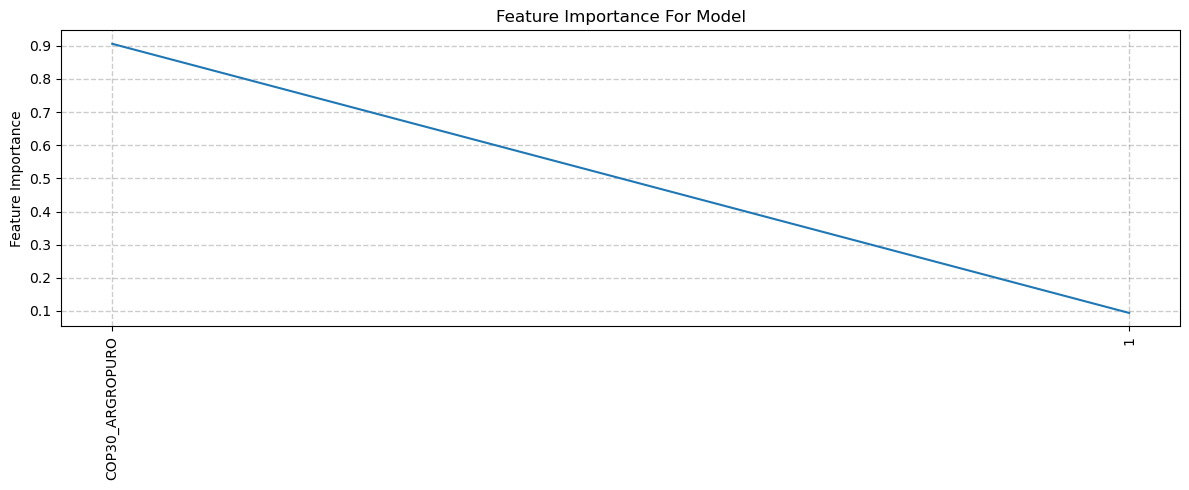

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Assuming you have already trained the rf_model (RandomForestClassifier) and have feature_importances available

# convert the list of feature importances to a data frame and sort it
fi_df = pd.DataFrame(index=data_bands, columns=['data'])
for i, f in enumerate(data_bands):
    fi_df.loc[f] = rf.feature_importances_[i]

# sort the feature importance by descending importance
fi_df = fi_df.sort_values(by=['data'], ascending=False)
d = fi_df.data.values

# plot the features
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(range(1, len(d) + 1), d)
ax.grid(color='k', linestyle='--', linewidth=1, alpha=0.2)
ax.set(title='Feature Importance For Model', ylabel='Feature Importance')
ax.set_xticks(range(1, len(d) + 1), minor=False)
ax.set_xticklabels(fi_df.index.values)
ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.savefig(os.path.join(outim_dir, 'f6_feature_importance.png'), dpi=250)
plt.show()


In [18]:
# generate a flattened copy of the data array to predict onto
#d = data_ar.copy()
#d = d.reshape((data_ar.shape[0], data_ar.shape[1]*data_ar.shape[2]))

## scale the pixel data to the unit variance (the 'z-score') and transpose
#for i in range(d.shape[0]):
#  d[i] = preprocessing.scale(d[i])
#d = d.T

## predict onto the data
#pred_unit = rf_model.predict(d)

## reshape the pred_unit array into the same shape as the raster, apply nulls
#pred_unit = pred_unit.T.reshape((data_ar.shape[1], data_ar.shape[2]))
#pred_unit[nulls] = np.nan

## plot the geology raster 
#fig, ax = plt.subplots(1, 2, figsize=(20,18))

## invert the dictionary to search unit_nums
#inv_unit_dict = dict((v, k) for k, v in unit_dict.items())

## nullyify the cover and NULL lithologies
#plt_ar = unit_ar.copy()
#plt_ar[plt_ar==inv_unit_dict['NULL']] = np.nan

## plot the two rasters with imshow
#true = ax[0].imshow(plt_ar, extent=extent, 
#                    cmap='Spectral', interpolation='nearest')
#ax[0].set(title='Mapped Rasterised Geologic Units')#

#pred = ax[1].imshow(pred_unit, extent=extent, 
#                    cmap='Spectral',interpolation='nearest')
#ax[1].set(title='Predicted Geologic Units')

## edit the tick labels, add a title and fix the bounds
#for axes in ax:
#  axes.set(ylabel='MGA52 mN', xlabel='MGA52 mE', aspect=1)
#  axes.set_ylim(gdf.total_bounds[[1,3]]) 
#  axes.set_xlim(gdf.total_bounds[[0,2]])
#  axes.ticklabel_format(style='plain')
#  axes.set(ylabel='MGA52 mN', xlabel='MGA52 mE')
#  plt.setp(axes.get_yticklabels(),va='center',rotation='vertical',fontsize='small')
#  plt.setp(axes.get_xticklabels(),fontsize='small')

## generate a legend and add to plot
#markers = [plt.Line2D([0,0],[0,0],color=c, marker='s', linestyle='') for c in colour_dict.values()]
#leg = ax[1].legend(markers, colour_dict.keys(), numpoints=1)
#leg.set_bbox_to_anchor((0, 0, 1.3, 1.01))

#plt.tight_layout()
#plt.savefig(os.path.join(outim_dir,'f7_mapped_vs_predicted.png'), dpi=180)
#plt.show()

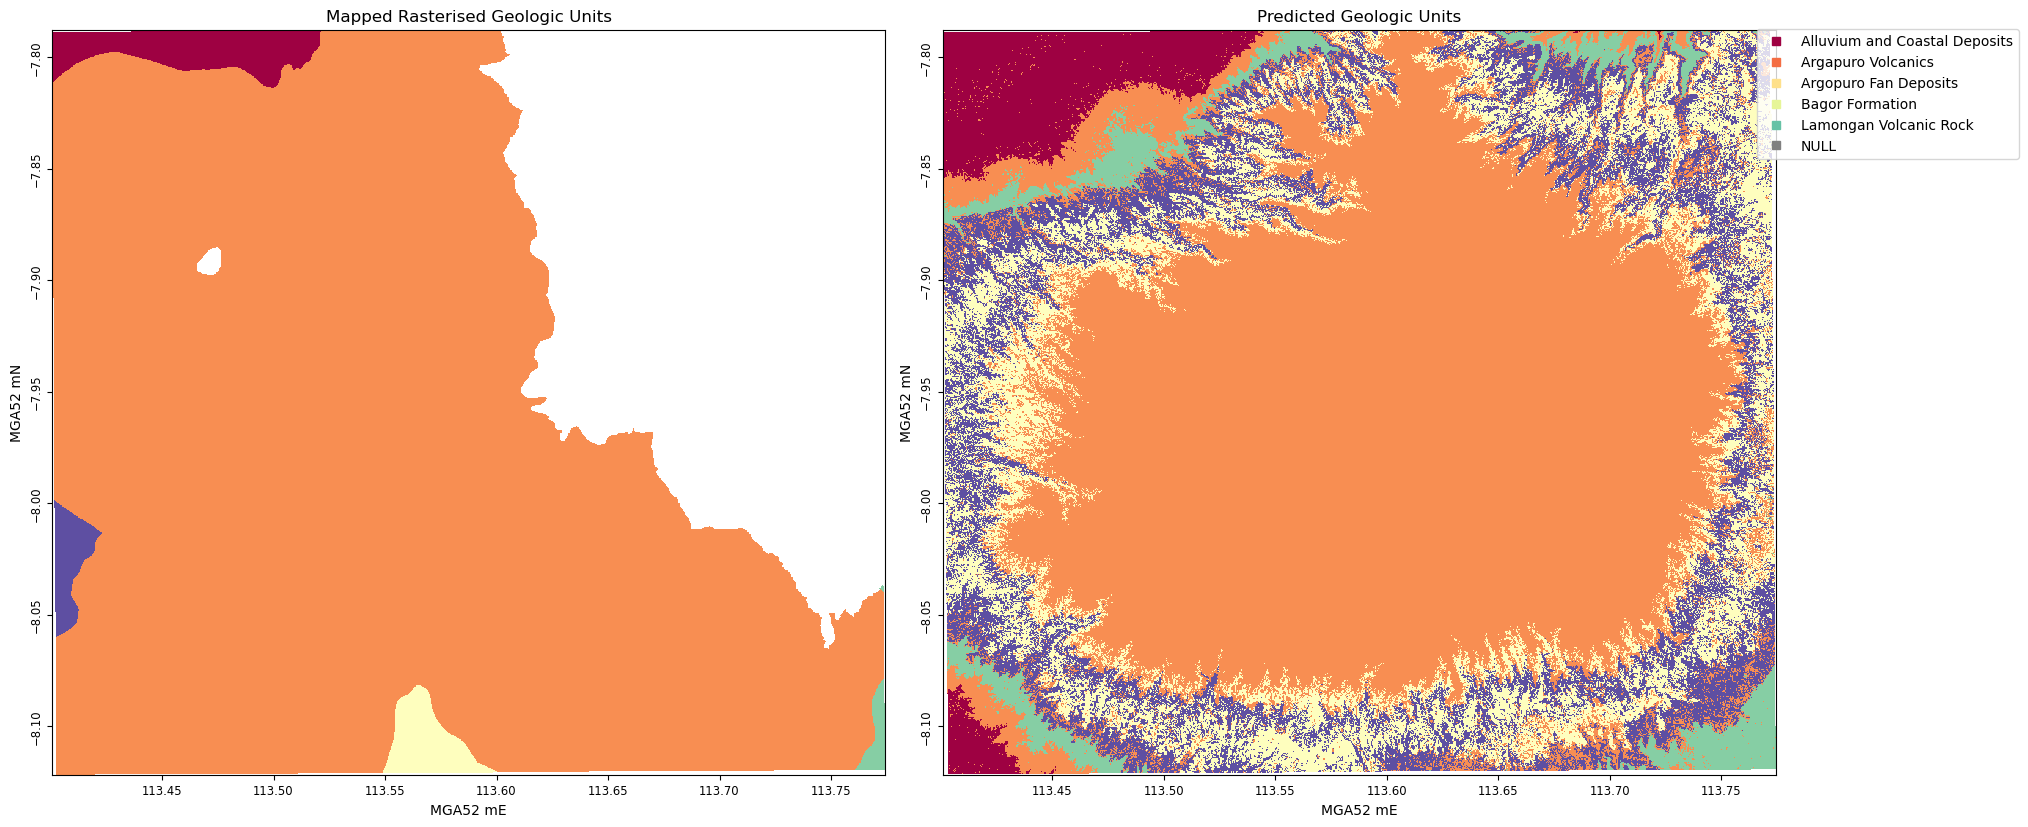

In [19]:
#(import numpy as np
from sklearn.preprocessing import scale
from sklearn.impute import SimpleImputer

# generate a flattened copy of the data array to predict onto
d = data_ar.copy()
d = d.reshape((data_ar.shape[0], data_ar.shape[1]*data_ar.shape[2]))

# scale the pixel data to the unit variance (the 'z-score') and transpose
for i in range(d.shape[0]):
    d[i] = scale(d[i])
d = d.T

# Create an imputer to fill missing values with the mean of each column
imputer = SimpleImputer(strategy='mean')
d_imputed = imputer.fit_transform(d)

# predict onto the data
pred_unit = rf_model.predict(d_imputed)

# reshape the pred_unit array into the same shape as the raster, apply nulls
pred_unit = pred_unit.T.reshape((data_ar.shape[1], data_ar.shape[2]))
pred_unit[nulls] = np.nan

# plot the geology raster 
fig, ax = plt.subplots(1, 2, figsize=(20,18))

# invert the dictionary to search unit_nums
inv_unit_dict = dict((v, k) for k, v in unit_dict.items())

# nullyify the cover and NULL lithologies
plt_ar = unit_ar.copy()
plt_ar[plt_ar==inv_unit_dict['NULL']] = np.nan

# plot the two rasters with imshow
true = ax[0].imshow(plt_ar, extent=extent, 
                    cmap='Spectral', interpolation='nearest')
ax[0].set(title='Mapped Rasterised Geologic Units')

pred = ax[1].imshow(pred_unit, extent=extent, 
                    cmap='Spectral',interpolation='nearest')
ax[1].set(title='Predicted Geologic Units')

# edit the tick labels, add a title and fix the bounds
for axes in ax:
    axes.set(ylabel='MGA52 mN', xlabel='MGA52 mE', aspect=1)
    axes.set_ylim(gdf.total_bounds[[1,3]]) 
    axes.set_xlim(gdf.total_bounds[[0,2]])
    axes.ticklabel_format(style='plain')
    axes.set(ylabel='MGA52 mN', xlabel='MGA52 mE')
    plt.setp(axes.get_yticklabels(),va='center',rotation='vertical',fontsize='small')
    plt.setp(axes.get_xticklabels(),fontsize='small')

# generate a legend and add to plot
markers = [plt.Line2D([0,0],[0,0],color=c, marker='s', linestyle='') for c in colour_dict.values()]
leg = ax[1].legend(markers, colour_dict.keys(), numpoints=1)
leg.set_bbox_to_anchor((0, 0, 1.3, 1.01))

plt.tight_layout()
plt.savefig(os.path.join(outim_dir,'f7_mapped_vs_predicted.png'), dpi=180)
plt.show()


In [ ]:
# loop through classes in the model
for unit in rf_model.classes_:
  # make a copies of the mapped and predicted geologic unit rasters
  g, p= unit_ar.copy(), pred_unit.copy()

  # set all pixels other than current unit to -1 in both arrays
  g[g != unit], p[p != unit] = -1, -1

  # nullify no data regions of both array
  g[unit_ar==inv_unit_dict['NULL']] = np.nan
  g[np.isnan(unit_ar)] = np.nan
  p[nulls] = np.nan

  # plot the geology rasters
  fig, ax = plt.subplots(1, 2, figsize=(7,7))

  # plot the two rasters with imshow
  true = ax[0].imshow(g, extent=extent, 
                      cmap='Oranges', interpolation='nearest')
  ax[0].set(title='Mapped - %s'%(unit_dict[unit]))

  pred = ax[1].imshow(p, extent=extent, 
                      cmap='Oranges',interpolation='nearest')
  ax[1].set(title='Predicted - %s'%(unit_dict[unit]))

  # edit the tick labels, add a title and fix the bounds
  for axes in ax:
    axes.set(ylabel='MGA52 mN', xlabel='MGA52 mE', aspect=1)
    axes.set_ylim(gdf.total_bounds[[1,3]]) 
    axes.set_xlim(gdf.total_bounds[[0,2]])
    axes.ticklabel_format(style='plain')
    axes.set(ylabel='MGA52 mN', xlabel='MGA52 mE')
    plt.setp(axes.get_yticklabels(),va='center',rotation='vertical',fontsize='small')
    plt.setp(axes.get_xticklabels(),fontsize='small')

  plt.tight_layout()
  plt.savefig(os.path.join(outim_dir,'f8_%s_feature_importance.png'%(unit_dict[unit])), dpi=250)
  plt.show()

In [ ]:
## import entropy function from sklearn
#from scipy.stats import entropy

## generate a prediction probability array on the 2D 'd' array
#pred_unit_proba = rf_model.predict_proba(d)

## compute the entropy values on the probabilities
#ent_unit = entropy(pred_unit_proba, base=2, axis=1)

## reshape the ent_unit array into the same shape as the raster, apply nulls
#ent_unit = ent_unit.T.reshape((data_ar.shape[1], data_ar.shape[2]))
#ent_unit[nulls] = np.nan

## set up a figure
#fig = plt.figure(figsize=(20,18))

## create a subplot axis for entropy raster
#ax1 = plt.subplot(121)
#ent_img = ax1.imshow(ent_unit, extent=extent, cmap='plasma')
#divider = make_axes_locatable(ax1)
#cax = divider.append_axes("bottom", size="3%", pad=0.5)
#plt.colorbar(ent_img, cax=cax, orientation='horizontal', label='Entropy (bits)')
#plt.setp(ax1.get_yticklabels(),va='center',rotation='vertical',fontsize='small')
#plt.setp(ax1.get_xticklabels(),fontsize='small')
#ax1.ticklabel_format(style='plain')
#ax1.set(ylabel='MGA52 mN', xlabel='MGA52 mE', title='Information Entropy', 
#        aspect=1)

# create a subplot axis for predicted lithology raster
#ax2 = plt.subplot(122)
#ax2.imshow(pred_unit, extent=extent, cmap='Spectral',interpolation='nearest')
#divider2 = make_axes_locatable(ax2)
#cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
#cax2.axis('off')
#plt.setp(ax2.get_yticklabels(),va='center',rotation='vertical',fontsize='small')
#plt.setp(ax2.get_xticklabels(),fontsize='small')
#ax2.ticklabel_format(style='plain')
#ax2.set(ylabel='MGA52 mN', xlabel='MGA52 mE', title='Predicted Geologic Units', 
#        aspect=1)

# generate a legend and add to plot
#markers = [plt.Line2D([0,0],[0,0],color=c, marker='s', linestyle='') for c in colour_dict.values()]
#leg = ax2.legend(markers, colour_dict.keys(), numpoints=1)
#leg.set_bbox_to_anchor((0, 0, 1.3, 1.01))

#plt.tight_layout()
#plt.savefig(os.path.join(outim_dir,'f9_entropy.png'), dpi=180)
#plt.show()

In [ ]:
import numpy as np
from sklearn.preprocessing import scale
from sklearn.impute import SimpleImputer
from scipy.stats import entropy

# generate a flattened copy of the data array to predict onto
d = data_ar.copy()
d = d.reshape((data_ar.shape[0], data_ar.shape[1]*data_ar.shape[2]))

# scale the pixel data to the unit variance (the 'z-score') and transpose
for i in range(d.shape[0]):
    d[i] = scale(d[i])
d = d.T

# Create an imputer to fill missing values with the mean of each column
imputer = SimpleImputer(strategy='mean')
d_imputed = imputer.fit_transform(d)

# generate a prediction probability array on the 2D 'd_imputed' array
pred_unit_proba = rf_model.predict_proba(d_imputed)

# compute the entropy values on the probabilities
ent_unit = entropy(pred_unit_proba, base=2, axis=1)

# reshape the ent_unit array into the same shape as the raster, apply nulls
ent_unit = ent_unit.T.reshape((data_ar.shape[1], data_ar.shape[2]))
ent_unit[nulls] = np.nan

# set up a figure
fig = plt.figure(figsize=(20,18))

# set up a figure
fig = plt.figure(figsize=(20,18))

# create a subplot axis for entropy raster
ax1 = plt.subplot(121)
ent_img = ax1.imshow(ent_unit, extent=extent, cmap='plasma')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("bottom", size="3%", pad=0.5)
plt.colorbar(ent_img, cax=cax, orientation='horizontal', label='Entropy (bits)')
plt.setp(ax1.get_yticklabels(),va='center',rotation='vertical',fontsize='small')
plt.setp(ax1.get_xticklabels(),fontsize='small')
ax1.ticklabel_format(style='plain')
ax1.set(ylabel='MGA52 mN', xlabel='MGA52 mE', title='Information Entropy', 
        aspect=1)

# create a subplot axis for predicted lithology raster
ax2 = plt.subplot(122)
ax2.imshow(pred_unit, extent=extent, cmap='Spectral',interpolation='nearest')
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')
plt.setp(ax2.get_yticklabels(),va='center',rotation='vertical',fontsize='small')
plt.setp(ax2.get_xticklabels(),fontsize='small')
ax2.ticklabel_format(style='plain')
ax2.set(ylabel='MGA52 mN', xlabel='MGA52 mE', title='Predicted Geologic Units', 
        aspect=1)

# generate a legend and add to plot
markers = [plt.Line2D([0,0],[0,0],color=c, marker='s', linestyle='') for c in colour_dict.values()]
leg = ax2.legend(markers, colour_dict.keys(), numpoints=1)
leg.set_bbox_to_anchor((0, 0, 1.3, 1.01))

plt.tight_layout()
plt.savefig(os.path.join(outim_dir,'f9_entropy.png'), dpi=180)
plt.show()


In [ ]:
# create output file names for the entropy and prediction rasters
ent_outfn = r'D:\KULIAH\Makan Bang\Agromo Mountain\Hasil\entropy_mga52.tif'
unit_outfn = r'D:\KULIAH\Makan Bang\Agromo Mountain\Hasil\pred_unit_mga52.tif'

# open the virtual raster to get metadata
with rasterio.open(vrt_fn, 'r') as src:
  # get metadata for the entropy and lithology rasters
  ent_kwargs, unit_kwargs = src.meta.copy(), src.meta.copy()

  # update the metadata for each 
  ent_kwargs.update({'count':1, 'driver':'GTiff','dtype':ent_unit.dtype})
  unit_kwargs.update({'count':1, 'driver':'GTiff','dtype':pred_unit.dtype})

  # open the entropy raster for saving
  with rasterio.open(ent_outfn, 'w', **ent_kwargs) as ent_dst:
    ent_dst.write(ent_unit, 1)

  # open the lithology raster for saving
  with rasterio.open(unit_outfn, 'w', **unit_kwargs) as unit_dst:
    unit_dst.write(pred_unit, 1)

# save geopandas data frame as a geopackage
gdf.to_file(r'D:\KULIAH\Makan Bang\Agromo Mountain\Hasil\Final_2', driver='GPKG')